In [7]:
import os
import time
import logging
import shutil
from math import ceil
from datetime import datetime
from importlib import reload  # Not needed in Python 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_score, balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from joblib import Memory
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

import onnx
from onnx import shape_inference
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType
from onnxruntime import InferenceSession

reload(logging)
%matplotlib inline

sns.set_context("notebook")
sns.set_theme(style="ticks")
sns.color_palette("rocket", as_cmap=True)


# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S', 
                    handlers=[
        logging.StreamHandler()
    ],)
logger = logging.getLogger(__name__)

# Create a memory object to cache the results
memory = Memory(location='cache', verbose=0)


## Reading Data and Extracting Feature Columns

In [2]:
input_file_path = "https://raw.githubusercontent.com/kaidalisohaib/AICohortW24/main/data/heart_disease_health_indicators_BRFSS2015.csv"

df = pd.read_csv(input_file_path, header = 0)

all_columns = df.columns.tolist()

# Define target column
target_column = "HeartDiseaseorAttack"

# Get all feature columns except one
all_features = all_columns
all_features.remove(target_column)

## Sampling the Dataset

In [3]:
# Sample the dataset
def sample_dataset(df, frac=0.1, random_state=42):
    logger.info("Sampling the dataset...")
    return df.sample(frac=frac, random_state=random_state)

# Split data into train and test sets
def split_train_test(sample_df, all_features, target_column, test_size=0.2, random_state=42):
    logger.info("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(sample_df[all_features], sample_df[target_column], test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Call the functions to sample the dataset and split train-test sets
sample_df = sample_dataset(df, 1)
X_train, X_test, y_train, y_test = split_train_test(sample_df, all_features, target_column)

# sampler = RandomUnderSampler(random_state=42)
sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

2024-03-08 20:32:00 - INFO - Sampling the dataset...
2024-03-08 20:32:00 - INFO - Splitting data into train and test sets...


## Pipeline Definition and Training

Using HistGradientBoostingClassifier instead of BoostingClassifier because it is faster for training and gives the same values.

In [12]:
# Set parameters
n_folds = 5
# C_values = [0.001, 0.01, 0.1, 1.0, 100.0]
# l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

# Best values, training everything takes time
C_values = [1.0]
l1_ratios = [0.5]

# Define the components
scaler = MinMaxScaler()

poly_features = PolynomialFeatures(degree=2)

classifier = LogisticRegressionCV(
    cv=n_folds,
    Cs=C_values,
    l1_ratios=l1_ratios,
    penalty="elasticnet",
    scoring="balanced_accuracy",
    solver="saga",
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    verbose=3
)


# Define the pipeline

pipeline = Pipeline(
    [("scaler", scaler), ("poly_features", poly_features), ("classifier", classifier)],
    verbose=True,
    memory="cache",
)


pipeline.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 15 epochs took 4 seconds
convergence after 15 epochs took 4 seconds
convergence after 15 epochs took 4 seconds
convergence after 15 epochs took 4 seconds
convergence after 23 epochs took 7 seconds
convergence after 25 epochs took 7 seconds
convergence after 25 epochs took 7 seconds
convergence after 32 epochs took 8 seconds
convergence after 59 epochs took 14 seconds
convergence after 72 epochs took 17 seconds
convergence after 76 epochs took 21 seconds
convergence after 93 epochs took 23 seconds
convergence after 362 epochs took 126 seconds
convergence after 404 epochs took 134 seconds
convergence after 368 epochs took 131 seconds
convergence after 458 epochs took 148 seconds
max_iter reached after 370 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 361 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 15 epochs took 4 seconds
convergence after 16 epochs took 5 seconds
convergence after 25 epochs took 13 seconds
max_iter reached after 358 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 54 epochs took 20 seconds
convergence after 16 epochs took 6 seconds
max_iter reached after 385 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 16 epochs took 5 seconds
convergence after 23 epochs took 8 seconds
convergence after 25 epochs took 8 seconds
convergence after 89 epochs took 33 seconds
convergence after 62 epochs took 20 seconds
convergence after 100 epochs took 30 seconds
convergence after 80 epochs took 24 seconds
convergence after 368 epochs took 153 seconds
convergence after 410 epochs took 177 seconds
convergence after 471 epochs took 187 seconds
convergence after 547 epochs took 209 seconds
max_iter reached after 456 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 401 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 16 epochs took 6 seconds
convergence after 16 epochs took 5 seconds
convergence after 33 epochs took 13 seconds
max_iter reached after 454 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 437 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 50 epochs took 20 seconds
convergence after 15 epochs took 7 seconds
convergence after 15 epochs took 6 seconds
convergence after 25 epochs took 9 seconds
convergence after 24 epochs took 9 seconds
convergence after 99 epochs took 43 seconds
convergence after 59 epochs took 25 seconds
convergence after 110 epochs took 44 seconds
convergence after 78 epochs took 36 seconds
convergence after 375 epochs took 149 seconds
convergence after 356 epochs took 147 seconds
convergence after 549 epochs took 195 seconds
convergence after 564 epochs took 207 seconds
max_iter reached after 395 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 15 epochs took 5 seconds
convergence after 26 epochs took 8 seconds
max_iter reached after 365 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 15 epochs took 4 seconds
max_iter reached after 420 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 375 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 33 epochs took 10 seconds
convergence after 77 epochs took 23 seconds
convergence after 15 epochs took 5 seconds
convergence after 16 epochs took 5 seconds
convergence after 25 epochs took 8 seconds
convergence after 53 epochs took 16 seconds
convergence after 102 epochs took 39 seconds
convergence after 63 epochs took 29 seconds
convergence after 135 epochs took 47 seconds
convergence after 393 epochs took 156 seconds
convergence after 376 epochs took 146 seconds
convergence after 384 epochs took 155 seconds
convergence after 425 epochs took 164 seconds
max_iter reached after 381 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 16 epochs took 7 seconds
convergence after 24 epochs took 8 seconds
max_iter reached after 372 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 16 epochs took 6 seconds
convergence after 26 epochs took 9 seconds
convergence after 67 epochs took 25 seconds
max_iter reached after 353 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 16 epochs took 5 seconds
max_iter reached after 402 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 32 epochs took 11 seconds
convergence after 15 epochs took 5 seconds
convergence after 88 epochs took 31 seconds
convergence after 50 epochs took 15 seconds
convergence after 107 epochs took 38 seconds
convergence after 138 epochs took 51 seconds
convergence after 396 epochs took 187 seconds
convergence after 428 epochs took 195 seconds
convergence after 516 epochs took 239 seconds
convergence after 561 epochs took 234 seconds
max_iter reached after 367 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 16 epochs took 5 seconds
convergence after 25 epochs took 9 seconds
max_iter reached after 370 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 16 epochs took 5 seconds
convergence after 76 epochs took 31 seconds
convergence after 23 epochs took 7 seconds
convergence after 57 epochs took 21 seconds
max_iter reached after 344 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 16 epochs took 5 seconds
max_iter reached after 323 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 15 epochs took 4 seconds
convergence after 25 epochs took 7 seconds
convergence after 31 epochs took 8 seconds
convergence after 83 epochs took 23 seconds
convergence after 104 epochs took 27 seconds
convergence after 360 epochs took 130 seconds
convergence after 418 epochs took 143 seconds
convergence after 493 epochs took 179 seconds
convergence after 635 epochs took 222 seconds
max_iter reached after 335 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 15 epochs took 3 seconds
convergence after 54 epochs took 14 seconds
max_iter reached after 329 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 123 epochs took 33 seconds
max_iter reached after 325 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 307 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 709 epochs took 261 seconds
max_iter reached after 275 seconds


c:\Users\Sohaib Kaidali\projects\git\AICohortW24\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 67.6min finished


convergence after 263 epochs took 91 seconds
[Pipeline] ........ (step 3 of 3) Processing classifier, total=69.1min


Pipeline(memory='cache',
         steps=[('scaler', MinMaxScaler()),
                ('poly_features', PolynomialFeatures()),
                ('classifier',
                 LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1.0, 100.0], cv=5,
                                      l1_ratios=[0.1, 0.3, 0.5, 0.7, 0.9],
                                      max_iter=1000, n_jobs=-1,
                                      penalty='elasticnet', random_state=42,
                                      scoring='balanced_accuracy',
                                      solver='saga', verbose=3))],
         verbose=True)

In [24]:
print("Best parameters:", pipeline.named_steps['classifier'].l1_ratio_)
print("Mean score with best parameters:", pipeline.named_steps['classifier'].C_)


Best parameters: [0.5]
Mean score with best parameters: [1.]


## Model Evaluation and Confusion Matrix Analysis

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     45898
         1.0       0.24      0.81      0.38      4838

    accuracy                           0.74     50736
   macro avg       0.61      0.77      0.61     50736
weighted avg       0.90      0.74      0.79     50736

Accuracy:  0.7426482182276885
Recall:  0.8112856552294336
F1-score:  0.37547232984167983
PR AUC Score:  0.36901102194340213
Balanced Accuracy Score:  0.7733494814994177


Text(47.25, 0.5, 'True label')

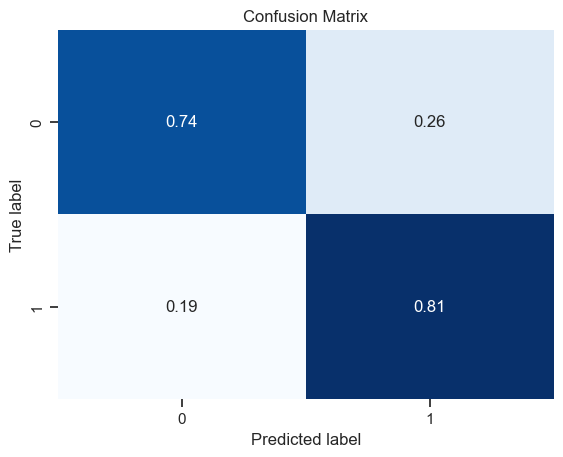

In [13]:
y_pred = pipeline.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)
pr_auc = average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1])
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
accuracy = report_dict["accuracy"]
recall = (
    report_dict["1.0"]["recall"] if "1.0" in report_dict else 0
)  # Recall for positive class
# F1-score for positive class
f1_score = report_dict["1.0"]["f1-score"] if "1.0" in report_dict else 0
# Calculate precision for positive class
positive_precision = precision_score(y_test, y_pred, pos_label=1)

print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("F1-score: ", f1_score)
print("PR AUC Score: ", pr_auc)
print("Balanced Accuracy Score: ", balanced_accuracy)


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)

# Set the title and labels for the subplot
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

## Converting and Saving Best Model to ONNX Format

In [14]:
initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]
final_types = [('label', Int64TensorType([None])),
              ('output', FloatTensorType([None, 2]))]

# Convert the best model to ONNX format with initial types
onnx_model = convert_sklearn(pipeline, "best_model", initial_types=initial_types, final_types=final_types, options={'zipmap': False})

# Infer shapes (optional but recommended)
onnx_model = shape_inference.infer_shapes(onnx_model)

# Define the path to save the ONNX model with timestamp
onnx_file_path = f'..\\models\\best_model.onnx'

# Save the ONNX model to a file
onnx.save_model(onnx_model, onnx_file_path)

# Log the saved best model
logger.info(f"Best model saved successfully at '{onnx_file_path}'.")

2024-03-08 22:50:28 - INFO - Best model saved successfully at '..\models\best_model.onnx'.


## Testing onnx model

In [15]:

target_test_value = 0
X_test_single_row = np.array(df[df[target_column] == target_test_value].iloc[:, 1:].head(10).values)
print(repr(X_test_single_row))
# Create an ONNX inference session with the loaded model
onnx_session = InferenceSession("..\\models\\best_model.onnx")
print(onnx_session)
output_meta_names = [output.name for output in onnx_session.get_outputs()]
print("Output metadata names:", output_meta_names)

# Convert the input data to a dictionary with the appropriate key
# input_data = {'input': X_test_single_row.astype(np.float32)}
input_data = {'input': X_test_single_row.astype(np.float32)}

# Run inference with the ONNX model
output = onnx_session.run(None, input_data)
print(output)
# Assuming you have only one output, you can access it like this
output_data = output[0]
print(sum(output_data==target_test_value)/len(output_data))

array([[ 1.,  1.,  1., 40.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         5., 18., 15.,  1.,  0.,  9.,  4.,  3.],
       [ 0.,  0.,  0., 25.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         3.,  0.,  0.,  0.,  0.,  7.,  6.,  1.],
       [ 1.,  1.,  1., 28.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
         5., 30., 30.,  1.,  0.,  9.,  4.,  8.],
       [ 1.,  0.,  1., 27.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         2.,  0.,  0.,  0.,  0., 11.,  3.,  6.],
       [ 1.,  1.,  1., 24.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         2.,  3.,  0.,  0.,  0., 11.,  5.,  4.],
       [ 1.,  1.,  1., 25.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         2.,  0.,  2.,  0.,  1., 10.,  6.,  8.],
       [ 1.,  0.,  1., 30.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         3.,  0., 14.,  0.,  0.,  9.,  6.,  7.],
       [ 1.,  1.,  1., 25.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
         3.,  0.,  0.,  1.,  0., 11.,  4.,  4.],
       [ 0.,  0.,  1., 2

Order for input:

1. HighBP
2. HighChol
3. CholCheck
4. BMI
5. Smoker
6. Stroke
7. Diabetes
8. PhysActivity
9. Fruits
10. Veggies
11. HvyAlcoholConsump
12. AnyHealthcare
13. NoDocbcCost
14. GenHlth
15. MentHlth
16. PhysHlth
17. DiffWalk
18. Sex
19. Age
20. Education
21. Income
